In [1]:
############################################
BaseDir      = 'IntroDDS/Chap03/'
OutputDir    = '3prep-0506StandardScalar2D/'
FileBaseName = '3prep-0506StandardScalar2D'

## Google Colabかどうかを判別し、このJupyter Notebookのあるディレクトリを特定します。

In [2]:
############################################
import sys
import os
############################################
def IsGoogleColab():
  if 'google.colab' in sys.modules:
    return True
  else:
    return False
############################################
if IsGoogleColab():
  #
  from google.colab import drive
  drive.mount('/content/drive')
  #
  IpynbDir = 'drive/My Drive/Colab Notebooks/' + BaseDir
else:
  #
  IpynbDir =  os.getcwd()
############################################
print( 'ipynb file path = %s' % IpynbDir )

Mounted at /content/drive
ipynb file path = drive/My Drive/Colab Notebooks/IntroDDS/Chap03/


## 必要なパッケージを読み込み、ファイルの出力先のディレクトリを用意します。

In [3]:
############################################
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
print('matplotlib Ver.', mpl.__version__)
#
############################################
import numpy as np
import numpy.random as rd
from numpy import linalg as LA
print('numpy      Ver.', np.__version__)
#
############################################
import sklearn as skl
import sklearn.linear_model as lm
import sklearn.preprocessing as prep
print('sklearn    Ver.', skl.__version__)
#
############################################
FilePath = IpynbDir + OutputDir
print( 'FilePath = %s' % FilePath )
#
if( True != os.path.isdir(FilePath) ):
    print('  making %s' % FilePath )
    os.mkdir(FilePath)
else:
    print(' %s is exist.' % FilePath )

matplotlib Ver. 3.7.1
numpy      Ver. 1.26.4
sklearn    Ver. 1.5.2
FilePath = drive/My Drive/Colab Notebooks/IntroDDS/Chap03/3prep-0506StandardScalar2D/
 drive/My Drive/Colab Notebooks/IntroDDS/Chap03/3prep-0506StandardScalar2D/ is exist.


# 多項式回帰を線形モデル
#$$
y_{i}
=
a_{0}
+
\sum_{k=1}^{K}
a_k
x_i^k
$$
- # $\boldsymbol{\omega}=(a_1, \cdots, a_k, \cdots, a_K)$
- # 計画行列 $\boldsymbol{X}$
## $$
\boldsymbol{X}
=
\left(
  \begin{array}{ccccc}
  x_1 & \cdots & x_1^k & \cdots & x_1^K \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_m & \cdots & x_m^k & \cdots & x_m^K \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_M & \cdots & x_M^k & \cdots & x_M^K
  \end{array}
\right)
$$
- # 線形写像
## $$
\boldsymbol{y}=\boldsymbol{X}\boldsymbol{\omega}+a_{0},
$$
## $$
\left(
  \begin{array}{c}
  y_1\\
  \vdots \\
  y_m \\
  \vdots \\
  y_M
  \end{array}
\right)
=
\left(
  \begin{array}{c}
  a_0\\
  \vdots \\
  a_0 \\
  \vdots \\
  a_0
  \end{array}
\right)
+
\left(
  \begin{array}{ccccc}
  x_1 & \cdots & x_1^k & \cdots & x_1^K \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_m & \cdots & x_m^k & \cdots & x_m^K \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_M & \cdots & x_M^k & \cdots & x_M^K
  \end{array}
\right)
\left(
  \begin{array}{c}
  a_1\\
  \vdots \\
  a_k \\
  \vdots \\
  a_K
  \end{array}
\right)
$$

# 真値を準備する
- ## $K=11$とする。
- ## $a_0=0.2,\,a_1=1.0,\,a_2=0.2,\,a_3=-0.3$ として、それ以外は0とする。
##$$
y=0.2+1.0x+0.2x^2-0.3x^3
$$

In [4]:
############################################
# y=0.2+1.0X+0.2X^{2}-0.3X^{3}
#
a_0 = 0.2
#
w_K = 11 - 1
#
w_true = np.zeros((w_K,))
# a_1
w_true[0] = 1.0
# a_2
w_true[1] = 0.2
# a_3
w_true[2] = -0.3
#
print(w_true)

[ 1.   0.2 -0.3  0.   0.   0.   0.   0.   0.   0. ]


# 解析データの準備
- # データ点数: $M=51$
- # $x$値の範囲: $x=[-2.0, +2.0]$

In [5]:
############################################
M = 51 # 201
#
x = np.linspace(-2.0,+2.0, num=M, endpoint=True)
#
print(x)

[-2.   -1.92 -1.84 -1.76 -1.68 -1.6  -1.52 -1.44 -1.36 -1.28 -1.2  -1.12
 -1.04 -0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16
 -0.08  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8
  0.88  0.96  1.04  1.12  1.2   1.28  1.36  1.44  1.52  1.6   1.68  1.76
  1.84  1.92  2.  ]


# 計画行列$X$の準備
## $$
\boldsymbol{X}
=
\left(
  \begin{array}{ccccc}
  x_1 & \cdots & x_1^k & \cdots & x_1^K \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_m & \cdots & x_m^k & \cdots & x_m^K \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_M & \cdots & x_M^k & \cdots & x_M^K
  \end{array}
\right)
$$

In [6]:
############################################
X = np.zeros((M, w_K))
#
for k in range(w_K):
    X[:,k] = x**(k+1)
#
print(X)

[[-2.00000000e+00  4.00000000e+00 -8.00000000e+00  1.60000000e+01
  -3.20000000e+01  6.40000000e+01 -1.28000000e+02  2.56000000e+02
  -5.12000000e+02  1.02400000e+03]
 [-1.92000000e+00  3.68640000e+00 -7.07788800e+00  1.35895450e+01
  -2.60919263e+01  5.00964985e+01 -9.61852772e+01  1.84675732e+02
  -3.54577406e+02  6.80788619e+02]
 [-1.84000000e+00  3.38560000e+00 -6.22950400e+00  1.14622874e+01
  -2.10906087e+01  3.88067201e+01 -7.14043650e+01  1.31384032e+02
  -2.41746618e+02  4.44813777e+02]
 [-1.76000000e+00  3.09760000e+00 -5.45177600e+00  9.59512576e+00
  -1.68874213e+01  2.97218616e+01 -5.23104763e+01  9.20664384e+01
  -1.62036931e+02  2.85184999e+02]
 [-1.68000000e+00  2.82240000e+00 -4.74163200e+00  7.96594176e+00
  -1.33827822e+01  2.24830740e+01 -3.77715644e+01  6.34562281e+01
  -1.06606463e+02  1.79098858e+02]
 [-1.60000000e+00  2.56000000e+00 -4.09600000e+00  6.55360000e+00
  -1.04857600e+01  1.67772160e+01 -2.68435456e+01  4.29496730e+01
  -6.87194767e+01  1.09951163e+02

# 真値データの準備。
# $$\boldsymbol{y}=\boldsymbol{X}\boldsymbol{\omega}+a_0$$

In [7]:
############################################
y_true = X @ w_true + a_0
#
print(y_true)

[ 1.4        1.1406464  0.9059712  0.6950528  0.5069696  0.3408
  0.1956224  0.0705152 -0.0354432 -0.1231744 -0.1936    -0.2476416
 -0.2862208 -0.3102592 -0.3206784 -0.3184    -0.3043456 -0.2794368
 -0.2445952 -0.2007424 -0.1488    -0.0896896 -0.0243328  0.0463488
  0.1214336  0.2        0.2811264  0.3638912  0.4473728  0.5306496
  0.6128     0.6929024  0.7700352  0.8432768  0.9117056  0.9744
  1.0304384  1.0788992  1.1188608  1.1494016  1.1696     1.1785344
  1.1752832  1.1589248  1.1285376  1.0832     1.0219904  0.9439872
  0.8482688  0.7339136  0.6      ]


# 誤差を重畳させたデータの準備。
- # $\boldsymbol{y}_{\rm wn}=\boldsymbol{y}_{\rm true}+{\cal N}(0,\sigma_{0});\;(\sigma_{0}=0.2)$

In [8]:
############################################
#
sigma0 = 0.2
#
y_wn = y_true + sigma0 * rd.randn(M).reshape(M,)
#
print(y_wn)

[ 1.38251819  1.45333817  0.94468915  0.54191026  0.57330343  0.09516215
  0.58527296  0.02320235  0.15082348 -0.12339849 -0.09726911  0.08336168
  0.09095157 -0.26589134 -0.57507451 -0.26896633 -0.3390947   0.01942041
 -0.18109149 -0.1363613  -0.25838781 -0.13061098 -0.36121883  0.1832504
  0.11463167 -0.01711028  0.27254804  0.50908457  0.64236795  0.51315019
  0.76791212  0.54917948  0.38704053  0.67953375  0.87624667  0.73881098
  0.79494072  1.04961771  1.45317125  1.60699057  1.17171772  1.02488467
  1.45387749  0.87213771  1.06904528  0.82367442  1.16955735  0.72675042
  0.67356578  0.67171163  0.57536305]


# グラフを描く関数

In [9]:
############################################
def Grf_data( x_data, y_sets, memo=None, title=None ):
  #
  plt.rcParams['font.size'] = 16
  #
  fig = plt.figure( figsize=(7,7) )
  fig.subplots_adjust(left=0.18, right=0.97, top=0.85, bottom=0.1)
  #
  ax1 = fig.add_subplot(1,1,1)
  #
  x_left, x_right = ax1.set_xlim( -2.2, 2.2 )
  ax1.set_xlabel( r'$x$' )
  #
  y_bot, y_top = ax1.set_ylim( -2.0, 2.0 )
  ax1.set_ylabel( r'$y$' )
  #
  for y_set in y_sets:
    # [y_data, plottype, label, 'color', size/linewidth, marker/linestyle]
    #   plottype = 0 -> plot
    #   plottype = 1 -> scatter
    if   y_set[1] == 0:
      #
      ax1.plot( x_data, y_set[0], label=y_set[2], color=y_set[3], linewidth=y_set[4], linestyle=y_set[5] )
      #
    elif y_set[1] == 1:
      #
      ax1.scatter( x_data, y_set[0], label=y_set[2], color=y_set[3], s=y_set[4], marker=y_set[5] )
      #
  #
  if title is not None:
    plt.title( title + r': $y_m=a_0 + \sum_{n=1}^{N}a_n x_m^n$' )
  else:
    plt.title( r'$y_m=a_0 + \sum_{n=1}^{N}a_n x_m^n$' )
  #
  plt.legend(loc='lower right')
  #
  if memo is not None:
    plt.text(x_left, y_bot, memo, fontsize=16,
             horizontalalignment='left',
             verticalalignment='bottom')

  #
  plt.show()
  #
  return fig

# データのグラフ描画

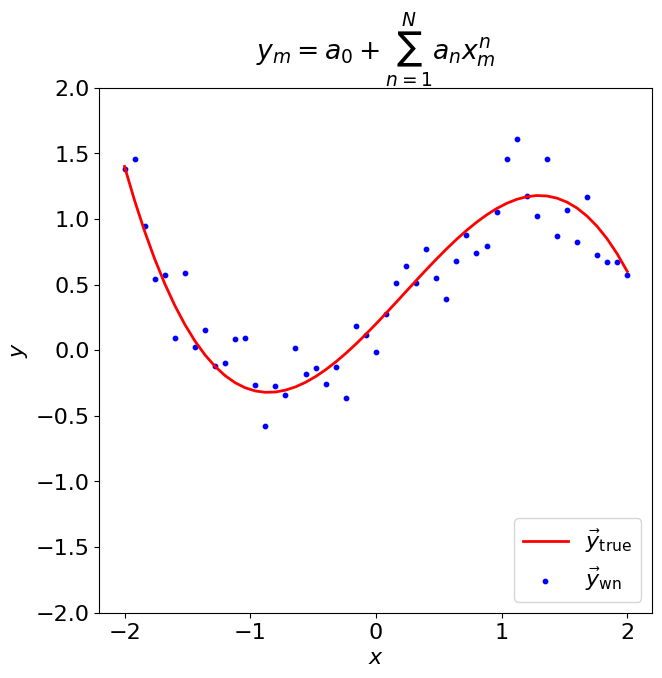

In [10]:
############################################
y_true_set = [ y_true, 0, r'$\vec{y}_{\rm true}$', 'red',  2, 'solid' ]
y_wn_set   = [ y_wn,   1, r'$\vec{y}_{\rm wn}$',    'blue', 10, 'o' ]
#
############################################
y_sets     = [ y_true_set, y_wn_set ]
fig = Grf_data( x, y_sets )
#
fig.savefig( FilePath + FileBaseName + '-data0.pdf' )

# 計画行列の各基底列の平均値と標準偏差

In [11]:
############################################
for k in range(w_K):
  #
  mean  = np.mean( X[:,k] )
  std   = np.std( X[:,k] )
  v_max = np.amax( X[:,k] )
  v_min = np.amin( X[:,k] )
  #
  print( 'k=%2d: min=%.3E, max=%.3E, mean=%.3E, std=%.3E' % (k+1, v_min, v_max, mean, std) )
  #

k= 1: min=-2.000E+00, max=2.000E+00, mean=3.483E-17, std=1.178E+00
k= 2: min=0.000E+00, max=4.000E+00, mean=1.387E+00, std=1.240E+00
k= 3: min=-8.000E+00, max=8.000E+00, mean=8.708E-17, std=3.204E+00
k= 4: min=0.000E+00, max=1.600E+01, mean=3.459E+00, std=4.605E+00
k= 5: min=-3.200E+01, max=3.200E+01, mean=4.876E-16, std=1.062E+01
k= 6: min=0.000E+00, max=6.400E+01, mean=1.027E+01, std=1.703E+01
k= 7: min=-1.280E+02, max=1.280E+02, mean=0.000E+00, std=3.771E+01
k= 8: min=0.000E+00, max=2.560E+02, mean=3.317E+01, std=6.403E+01
k= 9: min=-5.120E+02, max=5.120E+02, mean=2.229E-15, std=1.388E+02
k=10: min=0.000E+00, max=1.024E+03, mean=1.127E+02, std=2.440E+02


# データの標準化
- # sklearn.preprocessing.StandardScaler
- # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

## データに対し、以下の前処理を行う
1. ## 平均値$\mu$を差し引き
2. ## 単位分散にスケーリング

## して、特徴を標準化する。サンプル$x$の標準化は以下の式で計算される。
#$$
 z = \frac{x - \mu}{s}
$$
- ## $\mu$: サンプルの平均値。但し with_mean=False の場合は 0
- ## $s$学習サンプルの標準偏差。但しwith_std=False の場合は 1

# $\bullet$ 多次元配列 (n_samples, n_features) を想定しているため、(n_samples)] である1次元データに適用する場合は、reshapeしておく必要がある。

# 計画行列$X$を標準化する
- # 元行列:
## $$
\boldsymbol{X}
=
\left(
  \begin{array}{ccccc}
  X_{11} & \cdots & X_{1n} & \cdots & X_{1N} \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{m1} & \cdots & X_{mn} & \cdots & X_{mN} \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{M1} & \cdots & X_{Mn} & \cdots & X_{MN}
  \end{array}
\right)
$$

- # 標準化
# scalerX = prep.StandardScaler()
# scalerX.fit( X )
# X_ss = scalerX.transform( X )
## $$
\tilde{X_{mn}}=\frac{
  X_{mn}-\mu_n
}{
  s_n
}
$$
# 1. $\mu_n$:  scalerX.mean_[n]
# 2. $s_n$:    scalerX.scale_[n]

- # 標準化された行列:
# $$
\tilde{\boldsymbol{X}}
=
\left(
  \begin{array}{ccccc}
  \tilde{X_{11}} & \cdots & \tilde{X_{1n}} & \cdots & \tilde{X_{1N}} \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \tilde{X_{m1}} & \cdots & \tilde{X_{mn}} & \cdots & \tilde{X_{mN}} \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \tilde{X_{M1}} & \cdots & \tilde{X_{Mn}} & \cdots & \tilde{X_{MN}}
  \end{array}
\right)
$$
# 1. $\tilde{X_{1n}},\cdots, \tilde{X_{mn}}, \cdots, \tilde{X_{Mn}}$の平均値が0
# 2. $\tilde{X_{1n}},\cdots, \tilde{X_{mn}}, \cdots, \tilde{X_{Mn}}$の標準偏差が1
## に標準化される。


In [12]:
############################################
scalerX = prep.StandardScaler()
scalerX.fit( X )
#
X_ss = scalerX.transform( X )
#
############################################
for k in range(w_K):
  #
  mean = np.mean( X_ss[:,k] )
  std  = np.std( X_ss[:,k] )
  #
  print( 'k=%2d: mean=%+.3E, std=%.3E' % (k+1, mean, std) )
  #

k= 1: mean=+1.742E-17, std=1.000E+00
k= 2: mean=-8.708E-18, std=1.000E+00
k= 3: mean=+8.708E-18, std=1.000E+00
k= 4: mean=+1.132E-16, std=1.000E+00
k= 5: mean=+2.612E-17, std=1.000E+00
k= 6: mean=+1.219E-16, std=1.000E+00
k= 7: mean=-4.354E-17, std=1.000E+00
k= 8: mean=-1.306E-16, std=1.000E+00
k= 9: mean=+8.708E-18, std=1.000E+00
k=10: mean=+2.612E-17, std=1.000E+00


- # 標準化したものをもとに戻す
# X_ss_inv = scalerX.inverse_transform( X_ss )

In [13]:
############################################
X_ss_inv = scalerX.inverse_transform( X_ss )
############################################
# もとに戻っているか確認
for m in range(M):
    print((X_ss_inv[m]-X_ss_inv[m]) )

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0

# データの標準化
- # sklearn.preprocessing.StandardScaler
- # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
- # 属性(Attributes):
  - # scale_: (n_features,), 分散の平方根
  - # mean_: (n_features,), 平均値
  - # var_: (n_features,), 分散

# 1. $\mu_n$:  scalerX.mean_[n]
# 2. $s_n$:    scalerX.scale_[n]
# を使って、もとに戻るか確認。
## $$
X_{mn}
=
\tilde{X_{mn}}\,s_n+\mu_n
\;\;\;
\because\;
\tilde{X_{mn}}=\frac{
  X_{mn}-\mu_n
}{
  s_n
}
$$


In [14]:
############################################
# k=2の場合について確認する
k=2
scale_ = scalerX.scale_[k]
mean_  = scalerX.mean_[k]
#
print( 'scalerX.scale_ = %.3E' % scale_ )
print( 'scalerX.mean_  = %.3E' % mean_ )
############################################
for m in range(M):
  #
  #
  X_mk    = X[m,k]
  X_ss_mk = X_ss[m,k]
  #
  X_mk_inv = X_ss_mk * scale_ + mean_
  print( 'm=%3d: X_mk=+%.3E, X_ss_mk=+%.3E; X_ss_mk * scale_ + mean_ =+%.3E: residueal =%+.3E'
         % (m, X_mk, X_ss_mk, X_mk_inv, (X_mk-X_mk_inv)  ) )

scalerX.scale_ = 3.204E+00
scalerX.mean_  = 8.708E-17
m=  0: X_mk=+-8.000E+00, X_ss_mk=+-2.497E+00; X_ss_mk * scale_ + mean_ =+-8.000E+00: residueal =+0.000E+00
m=  1: X_mk=+-7.078E+00, X_ss_mk=+-2.209E+00; X_ss_mk * scale_ + mean_ =+-7.078E+00: residueal =+0.000E+00
m=  2: X_mk=+-6.230E+00, X_ss_mk=+-1.944E+00; X_ss_mk * scale_ + mean_ =+-6.230E+00: residueal =+0.000E+00
m=  3: X_mk=+-5.452E+00, X_ss_mk=+-1.701E+00; X_ss_mk * scale_ + mean_ =+-5.452E+00: residueal =+0.000E+00
m=  4: X_mk=+-4.742E+00, X_ss_mk=+-1.480E+00; X_ss_mk * scale_ + mean_ =+-4.742E+00: residueal =+0.000E+00
m=  5: X_mk=+-4.096E+00, X_ss_mk=+-1.278E+00; X_ss_mk * scale_ + mean_ =+-4.096E+00: residueal =+0.000E+00
m=  6: X_mk=+-3.512E+00, X_ss_mk=+-1.096E+00; X_ss_mk * scale_ + mean_ =+-3.512E+00: residueal =-4.441E-16
m=  7: X_mk=+-2.986E+00, X_ss_mk=+-9.318E-01; X_ss_mk * scale_ + mean_ =+-2.986E+00: residueal =+0.000E+00
m=  8: X_mk=+-2.515E+00, X_ss_mk=+-7.850E-01; X_ss_mk * scale_ + mean_ =+-2.515E+00: resid

# 解析対象のデータは、
# $\boldsymbol{y}=\boldsymbol{X}\boldsymbol{\omega}+a_0$

- # この両辺の平均を取ると、 $\overline{\boldsymbol{y}}=\overline{\boldsymbol{X}\boldsymbol{\omega}}+a_0$。

# 一方標準化した$\tilde{\boldsymbol{X}}$
# $$
\tilde{\boldsymbol{X}}
=
\left(
  \begin{array}{ccccc}
  \tilde{X_{11}} & \cdots & \tilde{X_{1n}} & \cdots & \tilde{X_{1N}} \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \tilde{X_{m1}} & \cdots & \tilde{X_{mn}} & \cdots & \tilde{X_{mN}} \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \tilde{X_{M1}} & \cdots & \tilde{X_{Mn}} & \cdots & \tilde{X_{MN}}
  \end{array}
\right)
$$
# の各列ベクトルの平均値が0になるように標準化されている。よって、どのような $\tilde{\boldsymbol{\omega}}$ を乗じても、その平均は
# $$
\overline{\tilde{\boldsymbol{X}}\,\tilde{\boldsymbol{\omega}}}
=\boldsymbol{0}
$$
# ゼロベクトルなる。

# よって、解析対象のデータは、
# $$
\boldsymbol{y}
=
\boldsymbol{X}\,\boldsymbol{\omega}+a_0
=
\tilde{\boldsymbol{X}}\,\tilde{\boldsymbol{\omega}}
+
\overline{\boldsymbol{y}}
$$
